# Experimental Analysis: Data, Transformations & Evaluation

This notebook consolidates essential experimental tasks for Marketing Mix Modeling:

1. **Data Sources** - Required data types and validation
2. **Transformations** - Adstock & Saturation with examples
3. **Evaluation** - Model metrics, diagnostics, and validation

---

## 1. Data Sources Overview

Unified-M requires 5 key data sources:

| Source | Required | Purpose | Key Fields |
|--------|----------|---------|------------|
| **Media Spend** | Yes | Independent variables (X) | date, channel, spend, impressions, clicks |
| **Outcomes** | Yes | Dependent variable (Y) | date, revenue, conversions |
| **Control Variables** | Optional | Confounding factors | date, holidays, promotions, macro indicators |
| **Incrementality Tests** | Optional | Ground truth calibration | channel, start_date, end_date, lift_estimate, lift_ci |
| **Attribution Data** | Optional | Touchpoint signals | date, channel, attributed_conversions |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sys
from pathlib import Path

# Add src to path
src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Import transform functions
from transforms.adstock import geometric_adstock, weibull_adstock
from transforms.saturation import hill_saturation, logistic_saturation
from models.evaluation import (
    compute_mape, compute_rmse, compute_r2, compute_mae,
    evaluate_model, compute_residual_diagnostics
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
np.random.seed(42)

print("Libraries and functions loaded!")

Libraries and functions loaded!


## 2. Generate Synthetic Data

Generate realistic synthetic data for experimentation.

In [2]:
# Generate media spend data
n_days = 365
dates = pd.date_range(end=datetime.now(), periods=n_days, freq='D')
channels = ['google', 'meta', 'tv', 'display']
base_spends = [2000, 1500, 3000, 800]

records = []
for date in dates:
    for channel, base_spend in zip(channels, base_spends):
        q4_multiplier = 1.3 if date.quarter == 4 else 1.0
        weekend_multiplier = 0.8 if date.dayofweek >= 5 else 1.0
        spend = base_spend * q4_multiplier * weekend_multiplier * np.random.uniform(0.8, 1.2)
        
        cpm = {'google': 5, 'meta': 8, 'tv': 15, 'display': 3}[channel]
        impressions = int(spend / cpm * 1000 * np.random.uniform(0.9, 1.1))
        ctr = {'google': 0.03, 'meta': 0.02, 'tv': 0, 'display': 0.005}[channel]
        clicks = int(impressions * ctr * np.random.uniform(0.8, 1.2))
        
        records.append({
            'date': date,
            'channel': channel,
            'spend': round(spend, 2),
            'impressions': impressions,
            'clicks': clicks
        })

media_spend = pd.DataFrame(records)
print(f"Generated {len(media_spend)} rows of media spend data")
print(f"Date range: {media_spend['date'].min().date()} to {media_spend['date'].max().date()}")
print(f"Total spend: ${media_spend['spend'].sum():,.0f}")
media_spend.head()

Generated 1460 rows of media spend data
Date range: 2025-02-10 to 2026-02-09
Total spend: $2,710,719


,date,channel,spend,impressions,clicks
0,2025-02-10 23:05:15.033511,google,1899.63,414174,13578
1,2025-02-10 23:05:15.033511,meta,1559.20,181491,3130
2,2025-02-10 23:05:15.033511,tv,2469.70,176704,0
3,2025-02-10 23:05:15.033511,display,866.58,261164,1551
4,2025-02-11 23:05:15.033511,google,2265.95,427117,11182


## 3. Adstock Transformation

Adstock models carryover effects - how past advertising affects current outcomes.

### Geometric Adstock

Exponential decay: `adstock[t] = x[t] + α × adstock[t-1]`

Parameters:
- **α (alpha)**: Decay rate [0, 1]. Higher = longer memory
- **Half-life**: Time for effect to decay to 50% = ln(0.5) / ln(α)

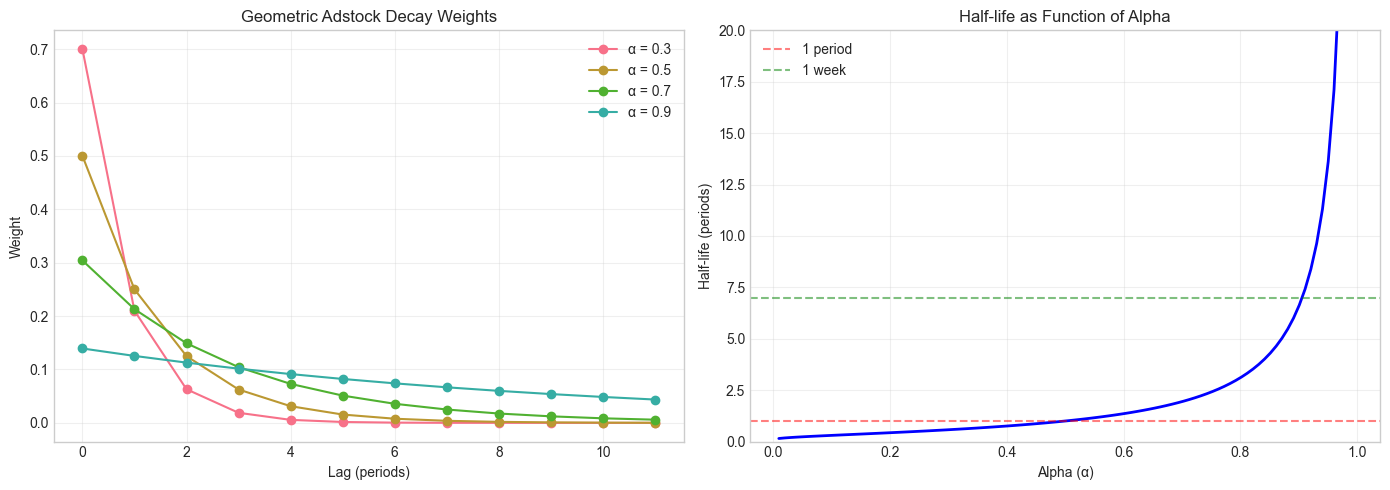


Half-life by Alpha:
------------------------------
α = 0.3: 0.6 periods
α = 0.5: 1.0 periods
α = 0.7: 1.9 periods
α = 0.8: 3.1 periods
α = 0.9: 6.6 periods
α = 0.95: 13.5 periods


In [3]:
# Visualize adstock decay weights
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

alphas = [0.3, 0.5, 0.7, 0.9]
l_max = 12
lags = np.arange(l_max)

for alpha in alphas:
    weights = np.array([alpha ** i for i in range(l_max)])
    weights_normalized = weights / weights.sum()
    axes[0].plot(lags, weights_normalized, 'o-', label=f'α = {alpha}', markersize=6)

axes[0].set_xlabel('Lag (periods)')
axes[0].set_ylabel('Weight')
axes[0].set_title('Geometric Adstock Decay Weights')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Half-life vs Alpha
alpha_range = np.linspace(0.01, 0.99, 100)
half_life = np.log(0.5) / np.log(alpha_range)

axes[1].plot(alpha_range, half_life, 'b-', linewidth=2)
axes[1].set_xlabel('Alpha (α)')
axes[1].set_ylabel('Half-life (periods)')
axes[1].set_title('Half-life as Function of Alpha')
axes[1].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='1 period')
axes[1].axhline(y=7, color='g', linestyle='--', alpha=0.5, label='1 week')
axes[1].set_ylim(0, 20)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nHalf-life by Alpha:")
print("-" * 30)
for alpha in [0.3, 0.5, 0.7, 0.8, 0.9, 0.95]:
    hl = np.log(0.5) / np.log(alpha)
    print(f"α = {alpha}: {hl:.1f} periods")

## 4. Saturation Transformation

Saturation models diminishing returns - doubling spend doesn't double response.

### Hill Function

Formula: `y = x^S / (K^S + x^S)`

Parameters:
- **K**: Half-saturation point (spend at 50% max effect)
- **S**: Hill coefficient (steepness of curve)

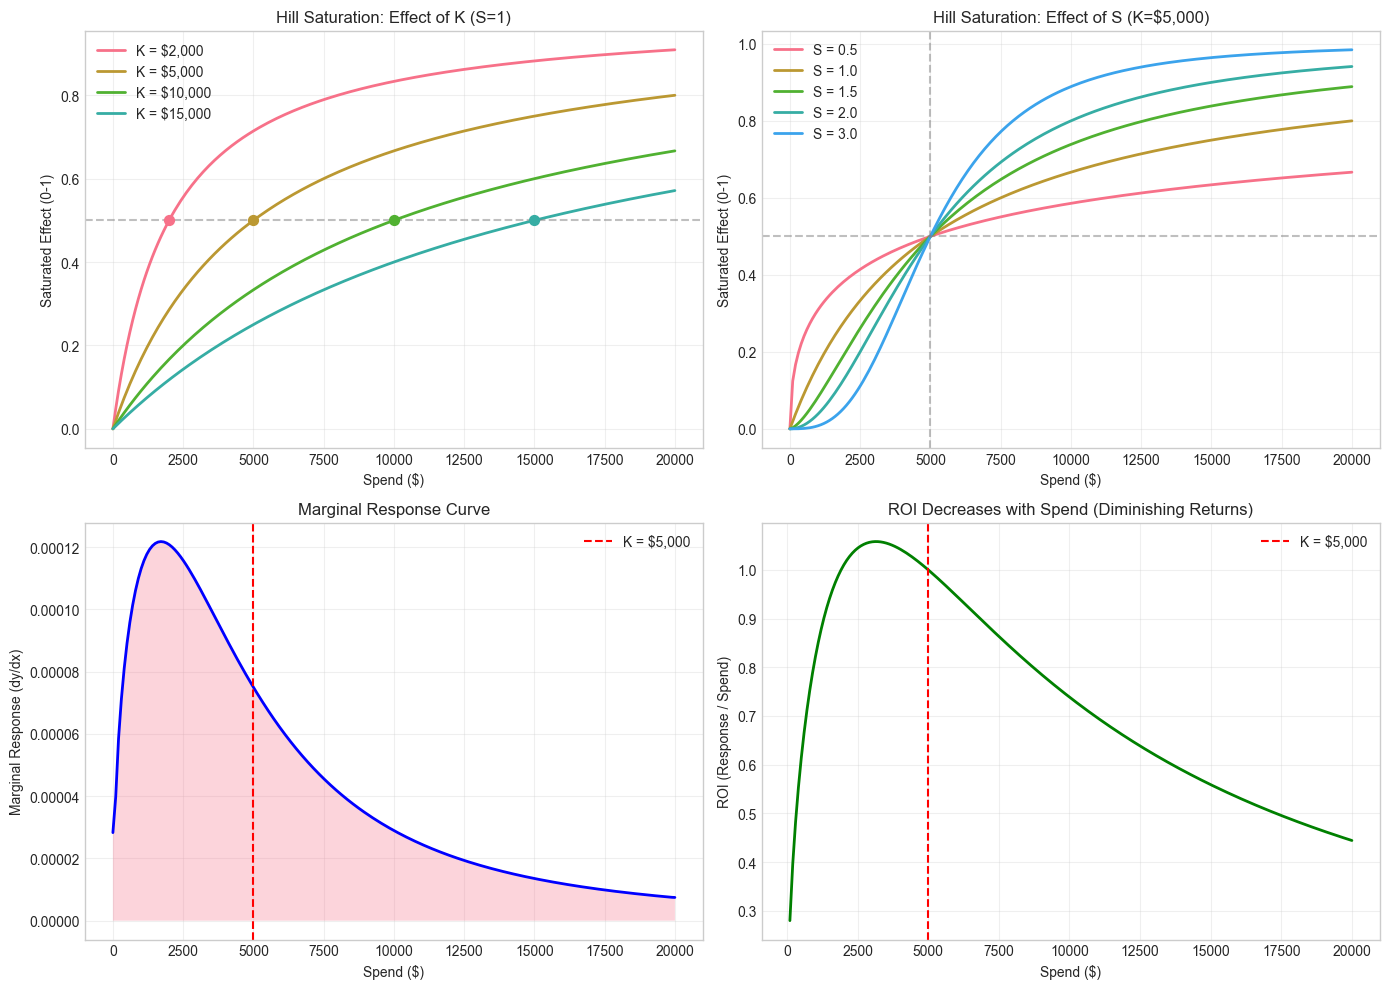

In [4]:
# Visualize Hill saturation function
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

spend = np.linspace(0, 20000, 200)

# Effect of K (half-saturation point)
K_values = [2000, 5000, 10000, 15000]
S = 1.0

for K in K_values:
    saturated = hill_saturation(spend, K=K, S=S)
    axes[0, 0].plot(spend, saturated, label=f'K = ${K:,}', linewidth=2)
    axes[0, 0].scatter([K], [0.5], s=50, zorder=5)

axes[0, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Spend ($)')
axes[0, 0].set_ylabel('Saturated Effect (0-1)')
axes[0, 0].set_title('Hill Saturation: Effect of K (S=1)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Effect of S (steepness)
K = 5000
S_values = [0.5, 1.0, 1.5, 2.0, 3.0]

for S in S_values:
    saturated = hill_saturation(spend, K=K, S=S)
    axes[0, 1].plot(spend, saturated, label=f'S = {S}', linewidth=2)

axes[0, 1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=K, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Spend ($)')
axes[0, 1].set_ylabel('Saturated Effect (0-1)')
axes[0, 1].set_title(f'Hill Saturation: Effect of S (K=${K:,})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Marginal response
K = 5000
S = 1.5
marginal = np.gradient(hill_saturation(spend, K=K, S=S), spend)

axes[1, 0].plot(spend, marginal, 'b-', linewidth=2)
axes[1, 0].fill_between(spend, marginal, alpha=0.3)
axes[1, 0].axvline(x=K, color='r', linestyle='--', label=f'K = ${K:,}')
axes[1, 0].set_xlabel('Spend ($)')
axes[1, 0].set_ylabel('Marginal Response (dy/dx)')
axes[1, 0].set_title('Marginal Response Curve')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# ROI at different spend levels
coefficient = 10000
total_response = coefficient * hill_saturation(spend, K=K, S=S)
roi = total_response / (spend + 1)

axes[1, 1].plot(spend[1:], roi[1:], 'g-', linewidth=2)
axes[1, 1].axvline(x=K, color='r', linestyle='--', label=f'K = ${K:,}')
axes[1, 1].set_xlabel('Spend ($)')
axes[1, 1].set_ylabel('ROI (Response / Spend)')
axes[1, 1].set_title('ROI Decreases with Spend (Diminishing Returns)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model Evaluation Metrics

Standard regression metrics for assessing model fit:

| Metric | Formula | Interpretation | Good Value |
|--------|---------|----------------|------------|
| **MAPE** | mean(abs(y - y_hat) / y) × 100 | % error, scale-independent | < 15% |
| **RMSE** | sqrt(mean((y - y_hat)^2)) | Error in original units | Context-dependent |
| **MAE** | mean(abs(y - y_hat)) | Average absolute error | Context-dependent |
| **R-squared** | 1 - SS_res/SS_tot | Variance explained | > 0.8 |

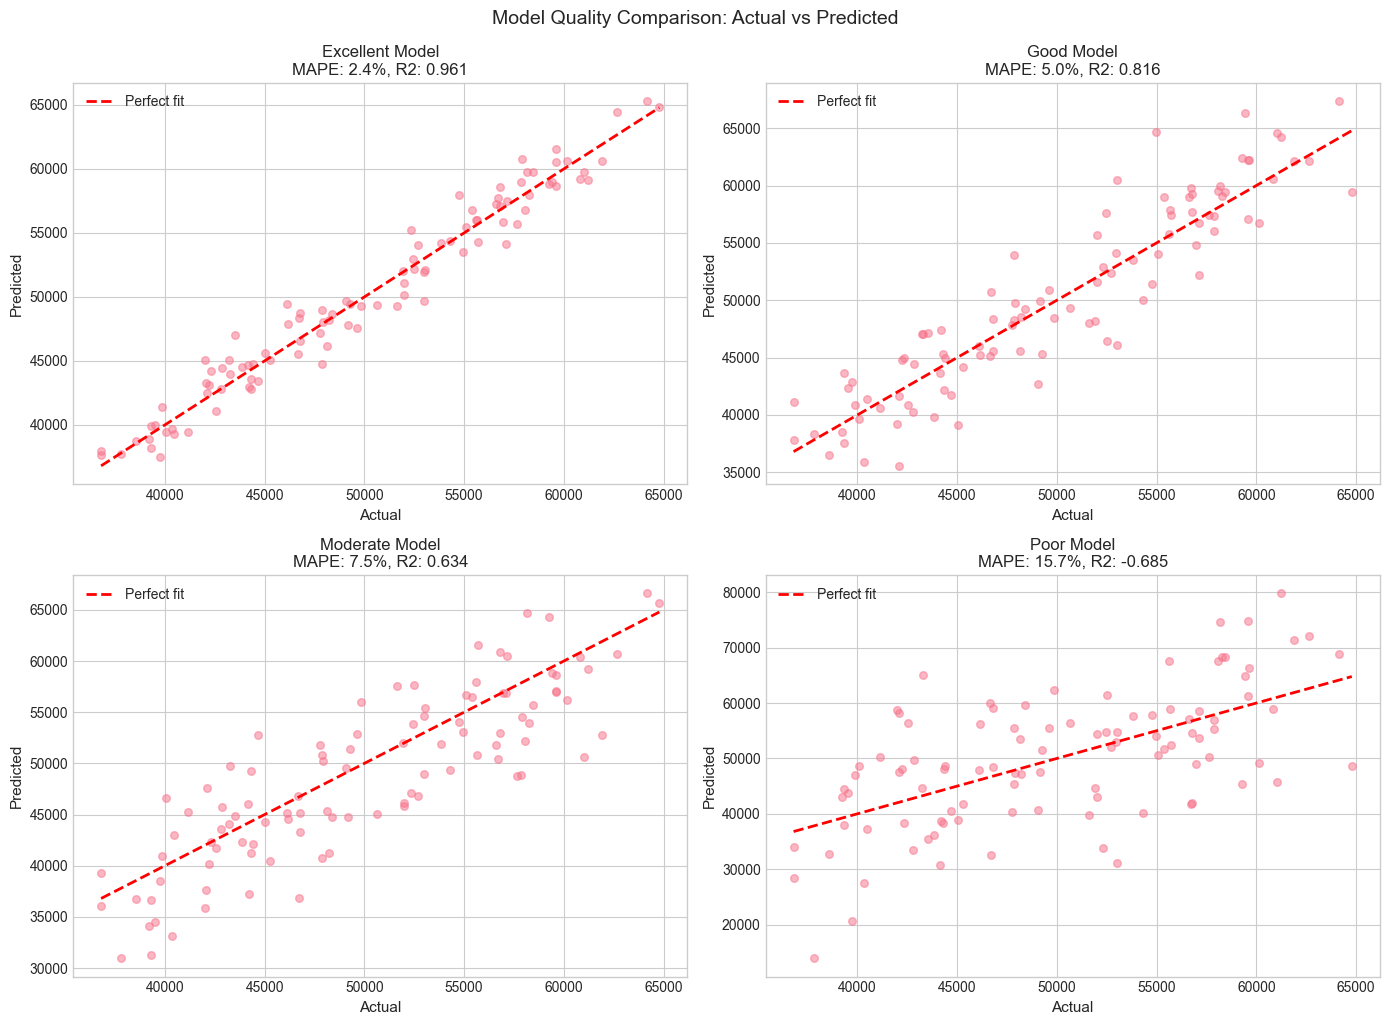


Metrics Summary:
Excellent: MAPE=2.37%, RMSE=1,446, R2=0.961
Good: MAPE=4.96%, RMSE=3,136, R2=0.816
Moderate: MAPE=7.46%, RMSE=4,426, R2=0.634
Poor: MAPE=15.75%, RMSE=9,498, R2=-0.685


In [5]:
# Generate example actual vs predicted data
n = 100
y_true = 50000 + 10000 * np.sin(np.linspace(0, 4*np.pi, n)) + np.random.normal(0, 3000, n)

# Simulate different model qualities
noise_levels = {'Excellent': 1500, 'Good': 3000, 'Moderate': 5000, 'Poor': 10000}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

results = {}
for idx, (quality, noise) in enumerate(noise_levels.items()):
    y_pred = y_true + np.random.normal(0, noise, n)
    
    metrics = evaluate_model(y_true, y_pred)
    results[quality] = metrics
    
    axes[idx].scatter(y_true, y_pred, alpha=0.5, s=30)
    axes[idx].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                   'r--', linewidth=2, label='Perfect fit')
    axes[idx].set_xlabel('Actual', fontsize=11)
    axes[idx].set_ylabel('Predicted', fontsize=11)
    title = f"{quality} Model\nMAPE: {metrics['mape']:.1f}%, R2: {metrics['r2']:.3f}"
    axes[idx].set_title(title, fontsize=12)
    axes[idx].legend()

plt.tight_layout()
plt.suptitle('Model Quality Comparison: Actual vs Predicted', y=1.02, fontsize=14)
plt.show()

print("\nMetrics Summary:")
print("=" * 60)
for quality, m in results.items():
    print(f"{quality}: MAPE={m['mape']:.2f}%, RMSE={m['rmse']:,.0f}, R2={m['r2']:.3f}")

## 6. Residual Analysis

Residuals (actual - predicted) reveal model problems:

| Pattern | Problem | Solution |
|---------|---------|----------|
| Trend in residuals | Missing trend component | Add trend term |
| Seasonality | Missing seasonality | Add Fourier terms |
| Heteroscedasticity | Variance changes | Log transform target |
| Autocorrelation | Missing dynamics | Add lagged terms |

Key diagnostics:
- **Durbin-Watson**: Tests for autocorrelation (target: close to 2)
- **Skewness**: Tests for symmetry (target: close to 0)
- **Kurtosis**: Tests for heavy tails (target: close to 0)

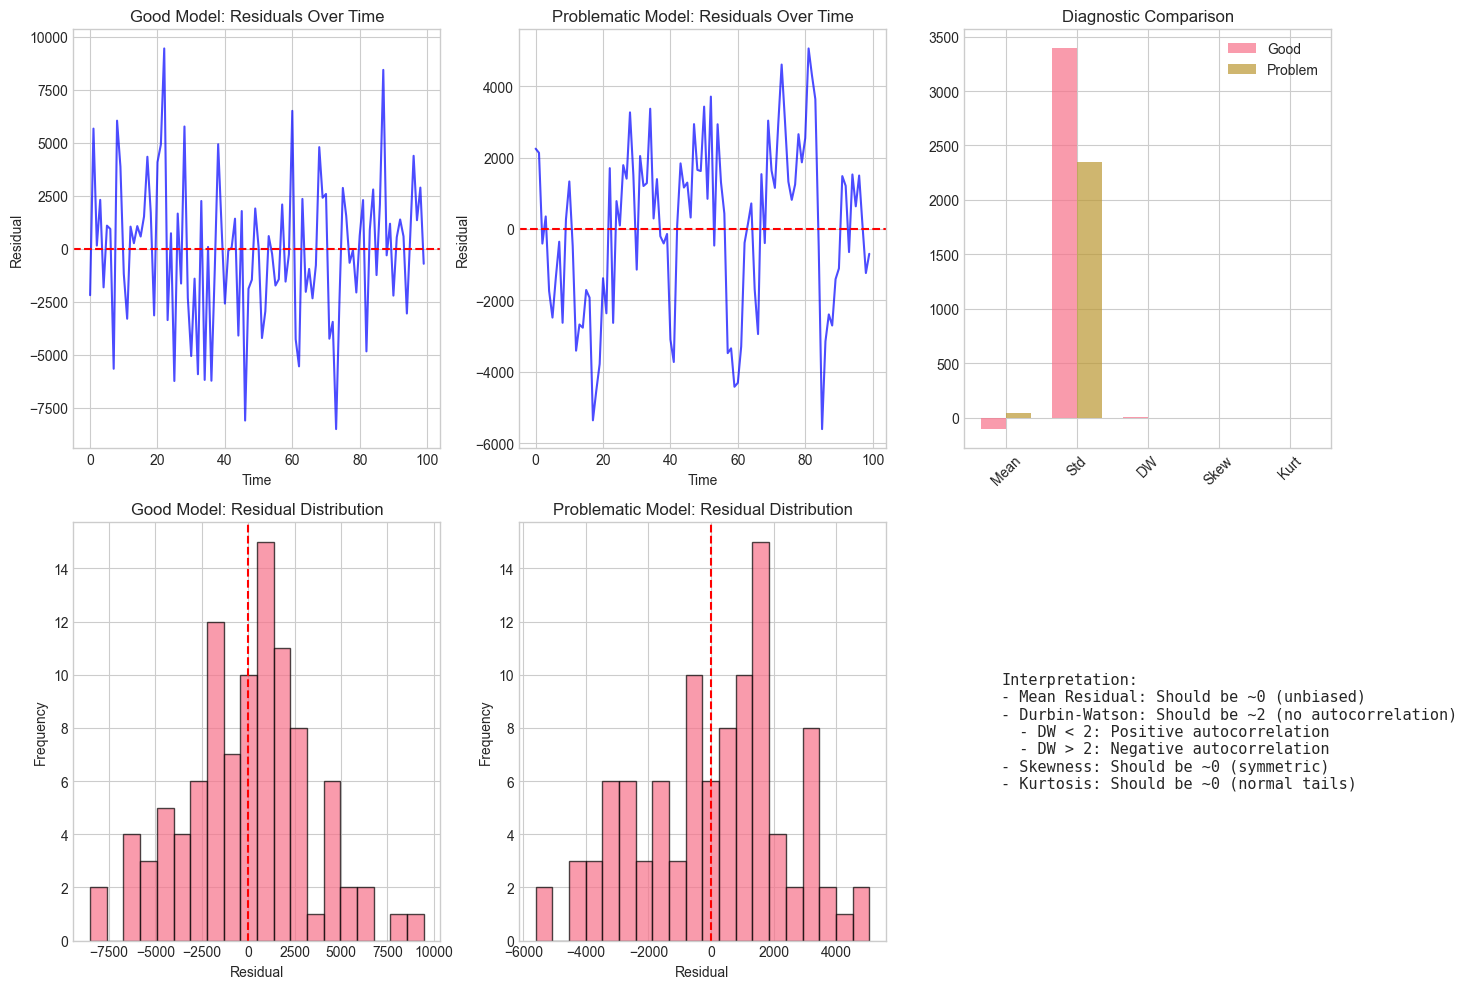


Diagnostic Values:

Good Model:
  mean_residual: -105.4930
  std_residual: 3391.0937
  skewness: 0.0584
  kurtosis: 0.2165
  durbin_watson: 1.9984

Problematic Model:
  mean_residual: 39.0304
  std_residual: 2349.5809
  skewness: -0.3011
  kurtosis: -0.5446
  durbin_watson: 0.7390


In [6]:
# Demonstrate residual diagnostics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Good model residuals (random, no pattern)
residuals_good = np.random.normal(0, 3000, 100)

# Bad model residuals (has autocorrelation)
residuals_bad = np.zeros(100)
residuals_bad[0] = np.random.normal(0, 3000)
for i in range(1, 100):
    residuals_bad[i] = 0.7 * residuals_bad[i-1] + np.random.normal(0, 2000)

for col, (residuals, title) in enumerate([(residuals_good, 'Good Model'), (residuals_bad, 'Problematic Model')]):
    # Residuals over time
    axes[0, col].plot(residuals, 'b-', alpha=0.7)
    axes[0, col].axhline(0, color='r', linestyle='--')
    axes[0, col].set_xlabel('Time')
    axes[0, col].set_ylabel('Residual')
    axes[0, col].set_title(f'{title}: Residuals Over Time')
    
    # Residual distribution
    axes[1, col].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
    axes[1, col].axvline(0, color='r', linestyle='--')
    axes[1, col].set_xlabel('Residual')
    axes[1, col].set_ylabel('Frequency')
    axes[1, col].set_title(f'{title}: Residual Distribution')

# Comparison of diagnostics
diagnostics = {
    'Good Model': compute_residual_diagnostics(np.zeros(100), -residuals_good),
    'Problematic Model': compute_residual_diagnostics(np.zeros(100), -residuals_bad),
}

metrics = ['mean_residual', 'std_residual', 'durbin_watson', 'skewness', 'kurtosis']
x = np.arange(len(metrics))
width = 0.35

axes[0, 2].bar(x - width/2, [diagnostics['Good Model'][m] for m in metrics], width, label='Good', alpha=0.7)
axes[0, 2].bar(x + width/2, [diagnostics['Problematic Model'][m] for m in metrics], width, label='Problem', alpha=0.7)
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(['Mean', 'Std', 'DW', 'Skew', 'Kurt'], rotation=45)
axes[0, 2].set_title('Diagnostic Comparison')
axes[0, 2].legend()

axes[1, 2].axis('off')

interpretation = '''
Interpretation:
- Mean Residual: Should be ~0 (unbiased)
- Durbin-Watson: Should be ~2 (no autocorrelation)
  - DW < 2: Positive autocorrelation
  - DW > 2: Negative autocorrelation
- Skewness: Should be ~0 (symmetric)
- Kurtosis: Should be ~0 (normal tails)
'''
axes[1, 2].text(0.1, 0.5, interpretation, fontsize=11, family='monospace',
                transform=axes[1, 2].transAxes, verticalalignment='center')

plt.tight_layout()
plt.show()

print("\nDiagnostic Values:")
print("=" * 50)
for model, diag in diagnostics.items():
    print(f"\n{model}:")
    for k, v in diag.items():
        print(f"  {k}: {v:.4f}")

## 7. Business Validation & Calibration

Statistical metrics aren't enough. Validate against business intuition:

### Sanity Checks

| Check | Question | Red Flag |
|-------|----------|----------|
| **ROI Reasonability** | Are channel ROIs plausible? | ROI > 10x or < 0 |
| **Contribution Shares** | Do shares match business understanding? | Organic is 0% |
| **Trend Direction** | Are trends in expected direction? | Revenue growing, model shows decline |
| **Seasonality** | Does seasonality match known patterns? | No Black Friday spike |
| **Coefficients** | Are signs correct? | Negative coefficient for paid media |

### Calibration with Experiments

Compare MMM estimates to incrementality test results:

| MMM vs Test | Possible Cause | Action |
|-------------|----------------|--------|
| MMM higher | MMM capturing correlation, not causation | Add controls, calibrate down |
| MMM lower | Test period unusual, MMM missing dynamics | Review test validity, calibrate up |
| Both align | Good! | Increase confidence |

## Summary

A good MMM should pass:

1. Statistical tests (MAPE < 15%, R-squared > 0.8)
2. Cross-validation (stable out-of-sample performance)
3. Residual analysis (no patterns, DW close to 2)
4. Business validation (makes intuitive sense)
5. Experimental calibration (aligns with test results)